In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

# Calls network

In [43]:
# Load the dataset
df_calls = pd.read_csv('./Data/calls.csv')

# Display the first few rows of the dataset
print(df_calls.head())

   timestamp  caller  callee  duration
0        184     300     301       121
1       3920     512     299       670
2       5623     301     300       504
3       9252     401     457        -1
4      15466     512       0         5


In [44]:
df_calls = df_calls.drop(columns=['timestamp', 'duration'])

# Display the modified dataset
print(df_calls.head())

   caller  callee
0     300     301
1     512     299
2     301     300
3     401     457
4     512       0


In [45]:
# Create a graph
G_calls = nx.Graph()

# Add nodes (callers and callees) to the graph
G_calls.add_nodes_from(np.unique(df_calls.values))

# Add edges to the graph
G_calls.add_edges_from(df_calls.values)

# Display basic graph information
print(nx.info(G_calls))

Name: 
Type: Graph
Number of nodes: 536
Number of edges: 621
Average degree:   2.3172


# SMS network

In [46]:
# Load the dataset
df_sms = pd.read_csv('./Data/sms.csv')

# Drop the 'timestamp' column
df_sms = df_sms.drop(columns=['timestamp'])

# Create a new column 'count' to store the number of times A texted B
df_sms['count'] = 1

# Group by sender and recipient, and sum the 'count' column to get unique combinations
df_sms_grouped = df_sms.groupby(['sender', 'recipient'], as_index=False).sum()

# Normalize the 'count' column
max_count = df_sms_grouped['count'].max()
df_sms_grouped['normalized_count'] = df_sms_grouped['count'] / max_count if max_count != 0 else 1

df_sms_grouped = df_sms_grouped.drop(columns=['count', 'normalized_count'])

df_sms = df_sms_grouped

# Display the first few rows of the grouped dataset
print(df_sms.head())

   sender  recipient
0       0        208
1       0        512
2       1        345
3       3         49
4       3        217


# Filtering the nodes that exist in all layers - Calls, SMS, Facebook

## Processing facebook dataset

In [47]:
# Load the 'fb_friends.csv' dataset
fb_friends_df = pd.read_csv('./Data/fb_friends.csv')

# Display the processed dataset
print(fb_friends_df.head())


G_fb_friends = nx.Graph()

nodes = set(fb_friends_df['# user_a']).union(set(fb_friends_df['user_b']))
G_fb_friends.add_nodes_from(nodes)
G_fb_friends.add_edges_from(fb_friends_df[['# user_a', 'user_b']].values)

   # user_a  user_b
0         0     512
1         0     263
2         0     525
3         0     285
4         0     543


## Filtering the nodes

In [48]:
# Identify common entities (nodes) across datasets
common_nodes = set(df_calls['caller']).intersection(set(df_calls['callee']))
common_nodes = common_nodes.intersection(set(df_sms_grouped['sender']))
common_nodes = common_nodes.intersection(set(df_sms_grouped['recipient']))
common_nodes = common_nodes.intersection(set(fb_friends_df['# user_a']))
common_nodes = common_nodes.intersection(set(fb_friends_df['user_b']))

# Filter dataframes to keep only common nodes
calls_df_common = df_calls[(df_calls['caller'].isin(common_nodes)) & (df_calls['callee'].isin(common_nodes))]
sms_df_common = df_sms_grouped[(df_sms_grouped['sender'].isin(common_nodes)) & (df_sms_grouped['recipient'].isin(common_nodes))]
fb_friends_df_common = fb_friends_df[(fb_friends_df['# user_a'].isin(common_nodes)) & (fb_friends_df['user_b'].isin(common_nodes))]

# # Display the resulting common dataframes
# print("Calls DataFrame (Common Nodes):\n", calls_df_common.head())
# print("SMS DataFrame (Common Nodes):\n", sms_df_common.head())
# print("Facebook Friends DataFrame (Common Nodes):\n", fb_friends_df_common.head())

# how many common nodes are there?
print(len(common_nodes))


296


In [49]:
G_calls = nx.Graph()
G_calls.add_nodes_from(common_nodes)
G_calls.add_edges_from(calls_df_common[['caller', 'callee']].values)
G_calls.add_edges_from(calls_df_common[['callee', 'caller']].values)

G_sms = nx.Graph()
G_sms.add_nodes_from(common_nodes)
G_sms.add_edges_from(sms_df_common[['sender', 'recipient']].values)
G_sms.add_edges_from(sms_df_common[['recipient', 'sender']].values)

G_fb_friends = nx.Graph()
G_fb_friends.add_nodes_from(common_nodes)
G_fb_friends.add_edges_from(fb_friends_df_common[['# user_a', 'user_b']].values)

# Print the number of nodes and edges for each graph
print("Number of nodes and edges in Calls Graph:")
print("Nodes:", len(G_calls.nodes))
print("Edges:", len(G_calls.edges))
print()

print("Number of nodes and edges in SMS Graph:")
print("Nodes:", len(G_sms.nodes))
print("Edges:", len(G_sms.edges))
print()

print("Number of nodes and edges in Facebook Friends Graph:")
print("Nodes:", len(G_fb_friends.nodes))
print("Edges:", len(G_fb_friends.edges))

Number of nodes and edges in Calls Graph:
Nodes: 296
Edges: 321

Number of nodes and edges in SMS Graph:
Nodes: 296
Edges: 320

Number of nodes and edges in Facebook Friends Graph:
Nodes: 296
Edges: 1782


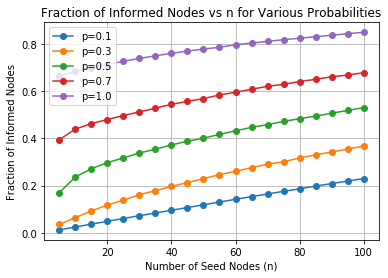

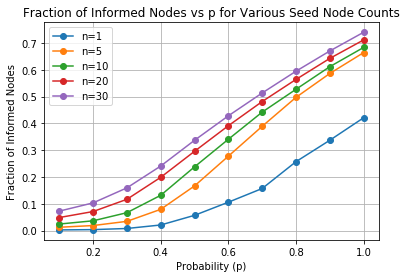

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random

# Function to create a graph from a dataframe
def create_graph(df, col1, col2):
    G = nx.Graph()
    G.add_nodes_from(df[col1].values)
    G.add_nodes_from(df[col2].values)
    for index, row in df.iterrows():
        G.add_edge(row[col1], row[col2])
    return G

# Function to simulate the spread of information
def spread_information(G, n, p, iterations=1000):
    nodes = list(G.nodes())
    total_spread = 0

    for _ in range(iterations):
        # Randomly seed n nodes with information
        seed_nodes = random.sample(nodes, n)
        informed_nodes = set(seed_nodes)
        new_informed = set(seed_nodes)

        while new_informed:
            current_new_informed = set()
            for node in new_informed:
                neighbors = list(G.neighbors(node))
                for neighbor in neighbors:
                    if neighbor not in informed_nodes and random.random() < p:
                        current_new_informed.add(neighbor)
            informed_nodes.update(current_new_informed)
            new_informed = current_new_informed

        total_spread += len(informed_nodes)
    
    average_spread = total_spread / iterations
    return average_spread / len(nodes)

# Function to plot fraction of informed nodes vs n for various probabilities
def plot_fraction_vs_n_for_multiple_p(G, p_values):
    n_values = list(range(5, 101, 5))

    plt.figure()

    for p in p_values:
        fractions = []
        for n in n_values:
            fraction = spread_information(G, n, p)
            fractions.append(fraction)
        plt.plot(n_values, fractions, marker='o', label=f'p={p}')

    plt.xlabel('Number of Seed Nodes (n)')
    plt.ylabel('Fraction of Informed Nodes')
    plt.title('Fraction of Informed Nodes vs n for Various Probabilities')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to plot fraction of informed nodes vs p for various seed node counts
def plot_fraction_vs_p_for_multiple_n(G, n_values):
    p_values = np.arange(0.1, 1.1, 0.1)

    plt.figure()

    for n in n_values:
        fractions = []
        for p in p_values:
            fraction = spread_information(G, n, p)
            fractions.append(fraction)
        plt.plot(p_values, fractions, marker='o', label=f'n={n}')

    plt.xlabel('Probability (p)')
    plt.ylabel('Fraction of Informed Nodes')
    plt.title('Fraction of Informed Nodes vs p for Various Seed Node Counts')
    plt.legend()
    plt.grid(True)
    plt.show()


# Creating graphs
calls_graph = create_graph(df_calls, 'caller', 'callee')
sms_graph = create_graph(df_sms, 'sender', 'recipient')
fb_friends_graph = create_graph(fb_friends_df, '# user_a', 'user_b')

G = calls_graph

plot_fraction_vs_n_for_multiple_p(G, p_values=[0.1, 0.3, 0.5, 0.7, 1.0])
plot_fraction_vs_p_for_multiple_n(G, n_values=[1, 5, 10, 20, 30])


In [51]:
# number of nodes and edges in the graph
print("Number of nodes and edges in Calls Graph:")
print("Nodes:", len(calls_graph.nodes))
print("Edges:", len(calls_graph.edges))
print()

print("Number of nodes and edges in SMS Graph:")
print("Nodes:", len(sms_graph.nodes))
print("Edges:", len(sms_graph.edges))
print()

print("Number of nodes and edges in Facebook Friends Graph:")
print("Nodes:", len(fb_friends_graph.nodes))
print("Edges:", len(fb_friends_graph.edges))


Number of nodes and edges in Calls Graph:
Nodes: 536
Edges: 621

Number of nodes and edges in SMS Graph:
Nodes: 568
Edges: 697

Number of nodes and edges in Facebook Friends Graph:
Nodes: 800
Edges: 6429


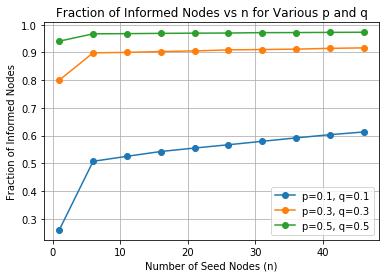

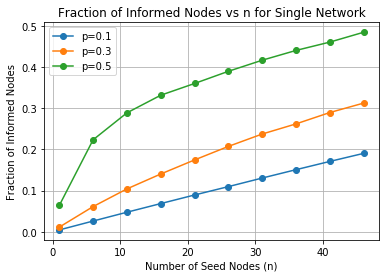

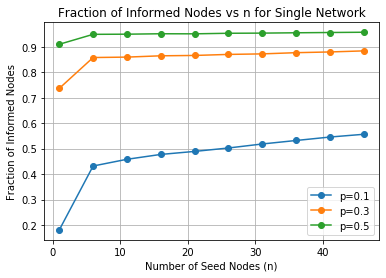

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random

# Function to simulate the spread of information across two graphs
def spread_information_cross_networks(sms_graph, fb_friends_graph, n, p, q, common_nodes, iterations=1000):
    nodes = list(common_nodes)
    total_spread = 0

    for _ in range(iterations):
        # Randomly seed n nodes with information
        seed_nodes = random.sample(nodes, n)
        informed_nodes = set(seed_nodes)
        new_informed = set(seed_nodes)

        while new_informed:
            current_new_informed_sms = set()
            current_new_informed_fb = set()

            # Spread information in the SMS graph
            for node in new_informed:
                neighbors = list(sms_graph.neighbors(node))
                for neighbor in neighbors:
                    if neighbor not in informed_nodes and random.random() < p:
                        current_new_informed_sms.add(neighbor)

            # Spread information in the Facebook graph
            for node in new_informed:
                neighbors = list(fb_friends_graph.neighbors(node))
                for neighbor in neighbors:
                    if neighbor not in informed_nodes and random.random() < q:
                        current_new_informed_fb.add(neighbor)

            # Update informed nodes
            new_informed = current_new_informed_sms.union(current_new_informed_fb)
            informed_nodes.update(new_informed)

        total_spread += len(informed_nodes)

    average_spread = total_spread / iterations
    return average_spread / (len(nodes))

# Function to plot fraction of informed nodes vs n for various p and q
def plot_fraction_vs_n_for_multiple_p_q(sms_graph, fb_friends_graph, p_values, q_values, common_nodes):
    n_values = list(range(1, 51, 5))

    plt.figure()

    for p, q in zip(p_values, q_values):
        fractions = []
        for n in n_values:
            fraction = spread_information_cross_networks(sms_graph, fb_friends_graph, n, p, q, common_nodes)
            fractions.append(fraction)
        plt.plot(n_values, fractions, marker='o', label=f'p={p}, q={q}')

    plt.xlabel('Number of Seed Nodes (n)')
    plt.ylabel('Fraction of Informed Nodes')
    plt.title('Fraction of Informed Nodes vs n for Various p and q')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to plot fraction of informed nodes vs n for single network with only p
def plot_fraction_vs_n_single_network(graph, p_values):
    n_values = list(range(1, 51, 5))

    plt.figure()

    for p in p_values:
        fractions = []
        for n in n_values:
            fraction = spread_information(graph, n, p)
            fractions.append(fraction)
        plt.plot(n_values, fractions, marker='o', label=f'p={p}')

    plt.xlabel('Number of Seed Nodes (n)')
    plt.ylabel('Fraction of Informed Nodes')
    plt.title('Fraction of Informed Nodes vs n for Single Network')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to simulate the spread of information in a single graph
def spread_information(G, n, p, iterations=1000):
    nodes = list(G.nodes())
    total_spread = 0

    for _ in range(iterations):
        # Randomly seed n nodes with information
        seed_nodes = random.sample(nodes, n)
        informed_nodes = set(seed_nodes)
        new_informed = set(seed_nodes)

        while new_informed:
            current_new_informed = set()
            for node in new_informed:
                neighbors = list(G.neighbors(node))
                for neighbor in neighbors:
                    if neighbor not in informed_nodes and random.random() < p:
                        current_new_informed.add(neighbor)
            informed_nodes.update(current_new_informed)
            new_informed = current_new_informed

        total_spread += len(informed_nodes)
    
    average_spread = total_spread / iterations
    return average_spread / len(nodes)


# Creating graphs
sms_graph = G_sms
fb_friends_graph = G_fb_friends

# Plotting for cross-network scenario
plot_fraction_vs_n_for_multiple_p_q(sms_graph, fb_friends_graph, p_values=[0.1, 0.3, 0.5], q_values=[0.1, 0.3, 0.5], common_nodes=common_nodes)

# Plotting for single network scenario
plot_fraction_vs_n_single_network(sms_graph, p_values=[0.1, 0.3, 0.5])

# Plotting for single network scenario
plot_fraction_vs_n_single_network(fb_friends_graph, p_values=[0.1, 0.3, 0.5])

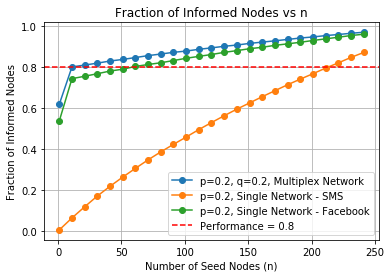

In [53]:
# Function to plot fraction of informed nodes vs n to compare the performance between single and multiplex network
def plot_fraction_vs_n_for_single_multiplex_network(sms_graph, fb_friends_graph, p_values, q_values, common_nodes):
    n_values = list(range(1, 251, 10))

    plt.figure()

    for p, q in zip(p_values, q_values):
        fractions = []
        for n in n_values:
            fraction = spread_information_cross_networks(sms_graph, fb_friends_graph, n, p, q, common_nodes)
            fractions.append(fraction)
        plt.plot(n_values, fractions, marker='o', label=f'p={p}, q={q}, Multiplex Network')
        
    for p in p_values:
        fractions = []
        for n in n_values:
            fraction = spread_information(sms_graph, n, p)
            fractions.append(fraction)
        plt.plot(n_values, fractions, marker='o', label=f'p={p}, Single Network - SMS')
        
    for p in p_values:
        fractions = []
        for n in n_values:
            fraction = spread_information(fb_friends_graph, n, p)
            fractions.append(fraction)
        plt.plot(n_values, fractions, marker='o', label=f'p={p}, Single Network - Facebook')
    
    plt.axhline(y=0.8, color = 'r', linestyle='--', label='Performance = 0.8')
    plt.xlabel('Number of Seed Nodes (n)')
    plt.ylabel('Fraction of Informed Nodes')
    plt.title('Fraction of Informed Nodes vs n')
    plt.legend()
    plt.grid(True)
    plt.show()
    
# Plotting for single networks and multiplex network
plot_fraction_vs_n_for_single_multiplex_network(sms_graph, fb_friends_graph, p_values=[0.2], q_values=[0.2], common_nodes=common_nodes)

## Spreding Information Based on Betweenness Centrality

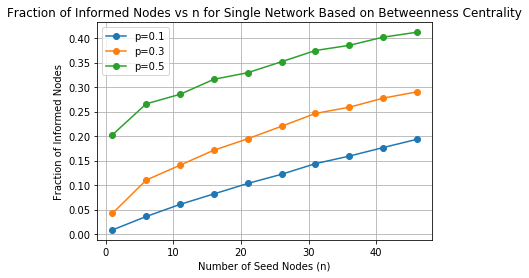

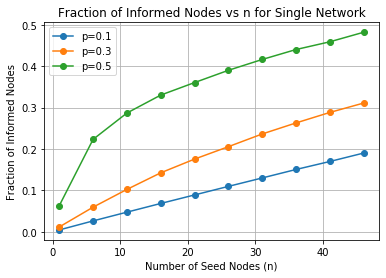

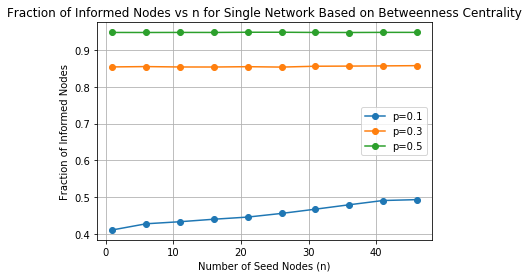

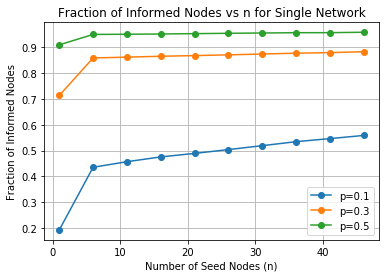

In [76]:
# Function to simulate the spread of information in a single graph based on centrality
def spread_information_centrality(G, n, p, iterations=1000):
    nodes = list(G.nodes())
    total_spread = 0
    
    # Calculating betweenness centrality
    betweenness_centrality = nx.betweenness_centrality(G)

    # Sorting nodes based on betweenness centrality (highest centrality first)
    sorted_nodes = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)

    for _ in range(iterations):
        
        top_nodes = sorted_nodes[:n]

        informed_nodes = set()
        new_informed = set()
        
        for node in top_nodes:
            informed_nodes.add(node[0])
            new_informed.add(node[0])


        while new_informed:
            current_new_informed = set()
            for node in new_informed:
                neighbors = list(G.neighbors(node))
                for neighbor in neighbors:
                    if neighbor not in informed_nodes and random.random() < p:
                        current_new_informed.add(neighbor)
            informed_nodes.update(current_new_informed)
            new_informed = current_new_informed

        total_spread += len(informed_nodes)
    
    average_spread = total_spread / iterations
    return average_spread / len(nodes)


# Function to plot fraction of informed nodes vs n for single network based on centrality
def plot_fraction_vs_n_single_network_centrality(graph, p_values):
    n_values = list(range(1, 51, 5))

    plt.figure()

    for p in p_values:
        fractions = []
        for n in n_values:
            fraction = spread_information_centrality(graph, n, p)
            fractions.append(fraction)
        plt.plot(n_values, fractions, marker='o', label=f'p={p}')

    plt.xlabel('Number of Seed Nodes (n)')
    plt.ylabel('Fraction of Informed Nodes')
    plt.title('Fraction of Informed Nodes vs n for Single Network Based on Betweenness Centrality')
    plt.legend()
    plt.grid(True)
    plt.show()
    

# Plotting for single network (sms) scenario based on centrality
plot_fraction_vs_n_single_network_centrality(sms_graph, p_values=[0.1, 0.3, 0.5])

#Plotting for single network (sms) scenario (random nodes)
plot_fraction_vs_n_single_network(sms_graph, p_values=[0.1, 0.3, 0.5])

# Plotting for single network (facebook) scenario based on centrality
plot_fraction_vs_n_single_network_centrality(fb_friends_graph, p_values=[0.1, 0.3, 0.5])

# Plotting for single network (facebook) scenario
plot_fraction_vs_n_single_network(fb_friends_graph, p_values=[0.1, 0.3, 0.5])

In [55]:
# Function to simulate the spread of information across two graphs based on centrality
def spread_information_cross_networks_centrality(sms_graph, fb_friends_graph, n, p, q, common_nodes, iterations=1000):
    
    nodes = list(common_nodes)
    total_spread = 0
    
    # Calculating betweenness centrality
    betweenness_centrality = nx.betweenness_centrality(sms_graph)

    # Sorting nodes based on betweenness centrality (highest centrality first)
    sorted_nodes = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)
    
    top_nodes = sorted_nodes[:n]

    for _ in range(iterations):    

        informed_nodes = set()
        new_informed = set()
        
        for node in top_nodes:
            informed_nodes.add(node[0])
            new_informed.add(node[0])
            

        while new_informed:
            current_new_informed_sms = set()
            current_new_informed_fb = set()

            # Spread information in the SMS graph
            for node in new_informed:
                neighbors = list(sms_graph.neighbors(node))
                for neighbor in neighbors:
                    if neighbor not in informed_nodes and random.random() < p:
                        current_new_informed_sms.add(neighbor)

            # Spread information in the Facebook graph
            for node in new_informed:
                neighbors = list(fb_friends_graph.neighbors(node))
                for neighbor in neighbors:
                    if neighbor not in informed_nodes and random.random() < q:
                        current_new_informed_fb.add(neighbor)

            # Update informed nodes
            new_informed = current_new_informed_sms.union(current_new_informed_fb)
            informed_nodes.update(new_informed)

        total_spread += len(informed_nodes)

    average_spread = total_spread / iterations
    return average_spread / (len(nodes))


# Function to plot fraction of informed nodes vs n for various p and q
def plot_fraction_vs_n_for_multiple_p_q_centrality(sms_graph, fb_friends_graph, p_values, q_values, common_nodes):
    n_values = list(range(1, 51, 5))

    plt.figure()

    for p, q in zip(p_values, q_values):
        fractions = []
        for n in n_values:
            fraction = spread_information_cross_networks_centrality(sms_graph, fb_friends_graph, n, p, q, common_nodes)
            fractions.append(fraction)
        plt.plot(n_values, fractions, marker='o', label=f'p={p}, q={q}')

    plt.xlabel('Number of Seed Nodes (n)')
    plt.ylabel('Fraction of Informed Nodes')
    plt.title('Fraction of Informed Nodes vs n for Various p and q Based on Betweenness Centrality')
    plt.legend()
    plt.grid(True)
    plt.show()

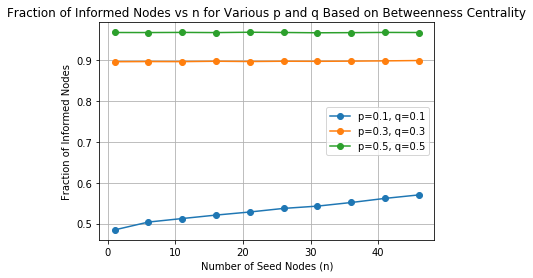

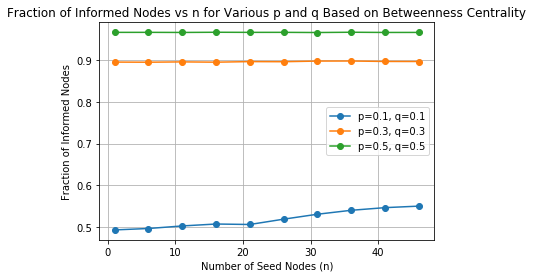

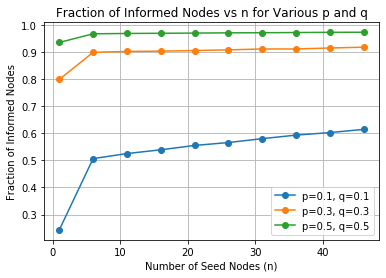

In [56]:
# Plotting for cross-network scenario based on centrality of sms_graph
plot_fraction_vs_n_for_multiple_p_q_centrality(sms_graph, fb_friends_graph, p_values=[0.1, 0.3, 0.5], q_values=[0.1, 0.3, 0.5], common_nodes=common_nodes)

# Plotting for cross-network scenario based on centrality of facebook_graph
plot_fraction_vs_n_for_multiple_p_q_centrality(fb_friends_graph, sms_graph, p_values=[0.1, 0.3, 0.5], q_values=[0.1, 0.3, 0.5], common_nodes=common_nodes)

# Plotting for cross-network scenario
plot_fraction_vs_n_for_multiple_p_q(sms_graph, fb_friends_graph, p_values=[0.1, 0.3, 0.5], q_values=[0.1, 0.3, 0.5], common_nodes=common_nodes)

## Spreding Information Based on Eigenvector Centrality

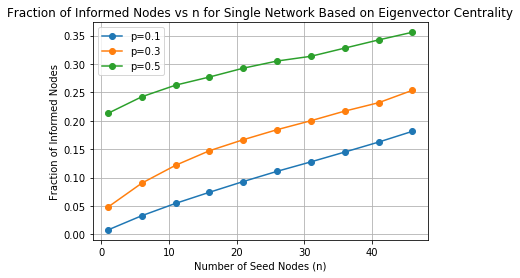

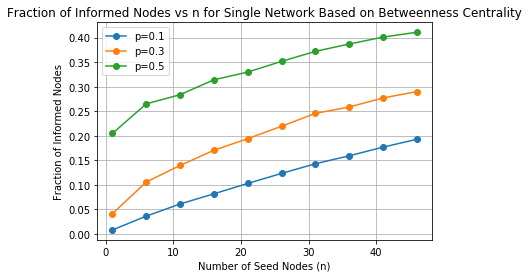

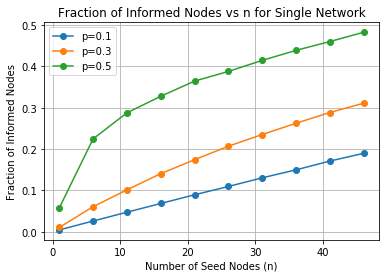

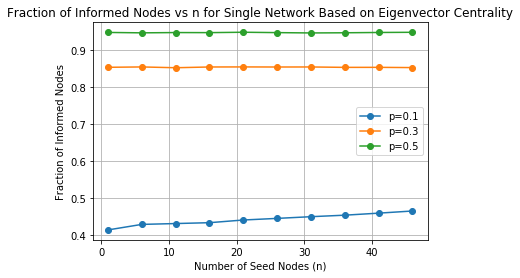

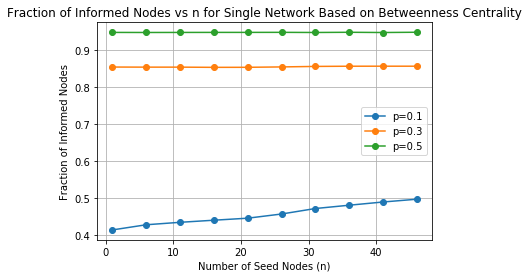

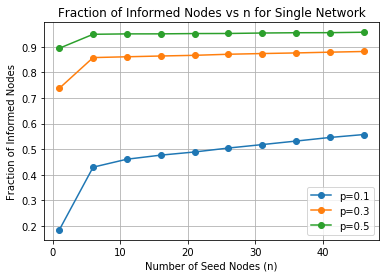

In [77]:
# Function to simulate the spread of information in a single graph based on eigenvector centrality
def spread_information_eigenvector_centrality(G, n, p, iterations=1000):
    nodes = list(G.nodes())
    total_spread = 0
    
    # Calculating betweenness centrality
    centrality = nx.eigenvector_centrality(G)


    # Sorting nodes based on betweenness centrality (highest centrality first)
    sorted_nodes = sorted(centrality.items(), key=lambda x: x[1], reverse=True)

    for _ in range(iterations):
        
        top_nodes = sorted_nodes[:n]

        informed_nodes = set()
        new_informed = set()
        
        for node in top_nodes:
            informed_nodes.add(node[0])
            new_informed.add(node[0])


        while new_informed:
            current_new_informed = set()
            for node in new_informed:
                neighbors = list(G.neighbors(node))
                for neighbor in neighbors:
                    if neighbor not in informed_nodes and random.random() < p:
                        current_new_informed.add(neighbor)
            informed_nodes.update(current_new_informed)
            new_informed = current_new_informed

        total_spread += len(informed_nodes)
    
    average_spread = total_spread / iterations
    return average_spread / len(nodes)


# Function to plot fraction of informed nodes vs n for single network based on centrality
def plot_fraction_vs_n_single_network_eigenvector_centrality(graph, p_values):
    n_values = list(range(1, 51, 5))

    plt.figure()

    for p in p_values:
        fractions = []
        for n in n_values:
            fraction = spread_information_eigenvector_centrality(graph, n, p)
            fractions.append(fraction)
        plt.plot(n_values, fractions, marker='o', label=f'p={p}')

    plt.xlabel('Number of Seed Nodes (n)')
    plt.ylabel('Fraction of Informed Nodes')
    plt.title('Fraction of Informed Nodes vs n for Single Network Based on Eigenvector Centrality')
    plt.legend()
    plt.grid(True)
    plt.show()
    

# Plotting for single network (sms) scenario based on eigenvector centrality
plot_fraction_vs_n_single_network_eigenvector_centrality(sms_graph, p_values=[0.1, 0.3, 0.5])

# Plotting for single network (sms) scenario based on centrality
plot_fraction_vs_n_single_network_centrality(sms_graph, p_values=[0.1, 0.3, 0.5])

#Plotting for single network (sms) scenario (random nodes)
plot_fraction_vs_n_single_network(sms_graph, p_values=[0.1, 0.3, 0.5])

# Plotting for single network (facebook) scenario based on eigenvector centrality
plot_fraction_vs_n_single_network_eigenvector_centrality(fb_friends_graph, p_values=[0.1, 0.3, 0.5])

# Plotting for single network (facebook) scenario based on centrality
plot_fraction_vs_n_single_network_centrality(fb_friends_graph, p_values=[0.1, 0.3, 0.5])

# Plotting for single network (facebook) scenario
plot_fraction_vs_n_single_network(fb_friends_graph, p_values=[0.1, 0.3, 0.5])

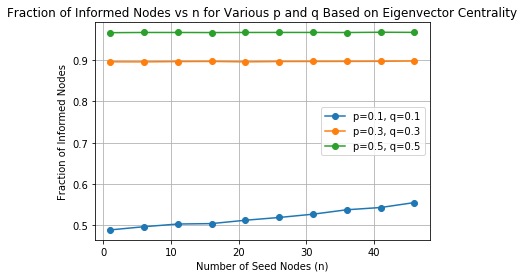

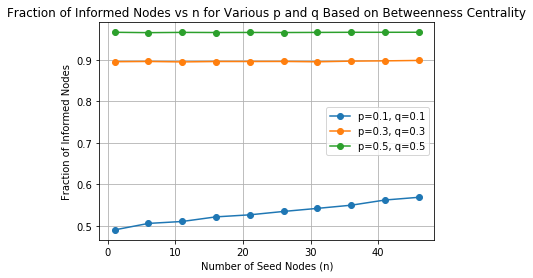

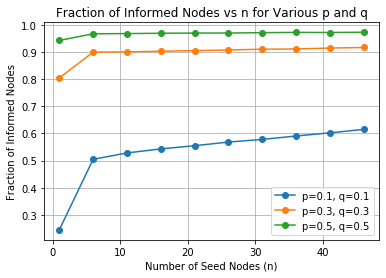

In [58]:
# Function to simulate the spread of information across two graphs based on Eigenvector centrality
def spread_information_cross_networks_eigenvector_centrality(sms_graph, fb_friends_graph, n, p, q, common_nodes, iterations=1000):
    
    nodes = list(common_nodes)
    total_spread = 0
    
    # Calculating betweenness centrality
    centrality = nx.eigenvector_centrality(sms_graph)

    # Sorting nodes based on betweenness centrality (highest centrality first)
    sorted_nodes = sorted(centrality.items(), key=lambda x: x[1], reverse=True)
    
    top_nodes = sorted_nodes[:n]

    for _ in range(iterations):    

        informed_nodes = set()
        new_informed = set()
        
        for node in top_nodes:
            informed_nodes.add(node[0])
            new_informed.add(node[0])
            

        while new_informed:
            current_new_informed_sms = set()
            current_new_informed_fb = set()

            # Spread information in the SMS graph
            for node in new_informed:
                neighbors = list(sms_graph.neighbors(node))
                for neighbor in neighbors:
                    if neighbor not in informed_nodes and random.random() < p:
                        current_new_informed_sms.add(neighbor)

            # Spread information in the Facebook graph
            for node in new_informed:
                neighbors = list(fb_friends_graph.neighbors(node))
                for neighbor in neighbors:
                    if neighbor not in informed_nodes and random.random() < q:
                        current_new_informed_fb.add(neighbor)

            # Update informed nodes
            new_informed = current_new_informed_sms.union(current_new_informed_fb)
            informed_nodes.update(new_informed)

        total_spread += len(informed_nodes)

    average_spread = total_spread / iterations
    return average_spread / (len(nodes))


# Function to plot fraction of informed nodes vs n for various p and q based on eigenvector centrality
def plot_fraction_vs_n_for_multiple_p_q_eigenvector_centrality(sms_graph, fb_friends_graph, p_values, q_values, common_nodes):
    n_values = list(range(1, 51, 5))

    plt.figure()

    for p, q in zip(p_values, q_values):
        fractions = []
        for n in n_values:
            fraction = spread_information_cross_networks_eigenvector_centrality(sms_graph, fb_friends_graph, n, p, q, common_nodes)
            fractions.append(fraction)
        plt.plot(n_values, fractions, marker='o', label=f'p={p}, q={q}')

    plt.xlabel('Number of Seed Nodes (n)')
    plt.ylabel('Fraction of Informed Nodes')
    plt.title('Fraction of Informed Nodes vs n for Various p and q Based on Eigenvector Centrality')
    plt.legend()
    plt.grid(True)
    plt.show()
    
# Plotting for cross-network scenario based on eigenvector centrality of sms_graph
plot_fraction_vs_n_for_multiple_p_q_eigenvector_centrality(sms_graph, fb_friends_graph, p_values=[0.1, 0.3, 0.5], q_values=[0.1, 0.3, 0.5], common_nodes=common_nodes)
 
# Plotting for cross-network scenario based on betweenness centrality of sms_graph
plot_fraction_vs_n_for_multiple_p_q_centrality(sms_graph, fb_friends_graph, p_values=[0.1, 0.3, 0.5], q_values=[0.1, 0.3, 0.5], common_nodes=common_nodes)

# Plotting for cross-network scenario
plot_fraction_vs_n_for_multiple_p_q(sms_graph, fb_friends_graph, p_values=[0.1, 0.3, 0.5], q_values=[0.1, 0.3, 0.5], common_nodes=common_nodes)

## Brute Force

In [65]:
# function to spread information from a node to its neighbors
def spread_brute_force(graph, start_nodes):
    informed = set()
    nodes = list(start_nodes)
    while nodes:
        current_node = nodes.pop(0)
        if current_node not in informed:
            informed.add(current_node)
            nodes.extend(set(graph.neighbors(current_node)) - informed)
    return informed

# function to find best nodes to spread information to have highest fraction on informed nodes at the end
def find_best_informing_nodes_brute_force(graph, n):
    selected_nodes = set()
    while len(selected_nodes) < n:
        max_informed = 0
        best_node = None
        for node in graph.nodes:
            if node not in selected_nodes:
                informed_nodes = spread_brute_force(graph, selected_nodes | {node})
                if len(informed_nodes) > max_informed:
                    best_node = node
        selected_nodes.add(best_node)
    return selected_nodes

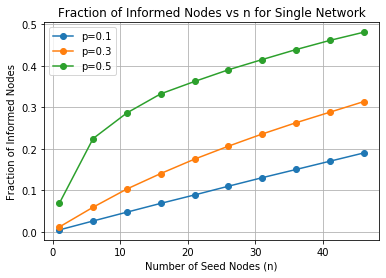

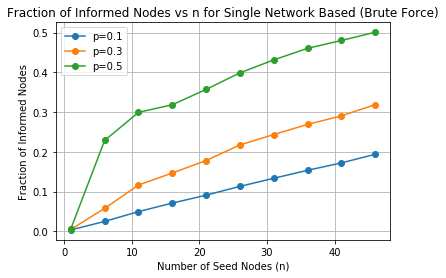

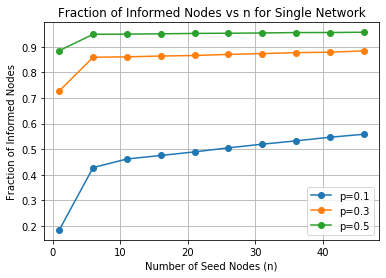

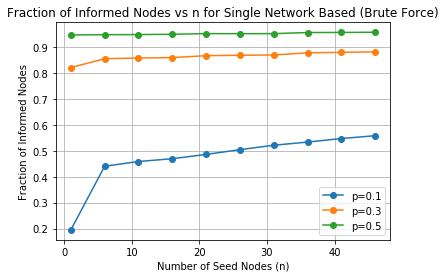

In [68]:
# Function to simulate the spread of information in a single graph (brute force)
def spread_information_brute_force(G, n, p, iterations=1000):
    nodes = list(G.nodes())
    total_spread = 0

    # Finding best nodes to spread information based on brute force
    top_nodes = find_best_informing_nodes_brute_force(G, n)
    
    
    
    for _ in range(iterations):
        
        informed_nodes = set(top_nodes)
        new_informed = set(top_nodes)

        while new_informed:
            current_new_informed = set()
            for node in new_informed:
                neighbors = list(G.neighbors(node))
                for neighbor in neighbors:
                    if neighbor not in informed_nodes and random.random() < p:
                        current_new_informed.add(neighbor)
            informed_nodes.update(current_new_informed)
            new_informed = current_new_informed

        total_spread += len(informed_nodes)
    
    average_spread = total_spread / iterations
    return average_spread / len(nodes)


# Function to plot fraction of informed nodes vs n for single network (brute force)
def plot_fraction_vs_n_single_network_brute_force(graph, p_values):
    n_values = list(range(1, 51, 5))

    plt.figure()

    for p in p_values:
        fractions = []
        for n in n_values:
            fraction = spread_information_brute_force(graph, n, p)
            fractions.append(fraction)
        plt.plot(n_values, fractions, marker='o', label=f'p={p}')

    plt.xlabel('Number of Seed Nodes (n)')
    plt.ylabel('Fraction of Informed Nodes')
    plt.title('Fraction of Informed Nodes vs n for Single Network Based (Brute Force)')
    plt.legend()
    plt.grid(True)
    plt.show()
    


#Plotting for single network (sms) scenario (random nodes)
plot_fraction_vs_n_single_network(sms_graph, p_values=[0.1, 0.3, 0.5])

#Plotting for single network (sms) scenario (brute force)
plot_fraction_vs_n_single_network_brute_force(sms_graph, p_values=[0.1, 0.3, 0.5])

# Plotting for single network (facebook) scenario
plot_fraction_vs_n_single_network(fb_friends_graph, p_values=[0.1, 0.3, 0.5])

# Plotting for single network (facebook) (brute force)
plot_fraction_vs_n_single_network_brute_force(fb_friends_graph, p_values=[0.1, 0.3, 0.5])

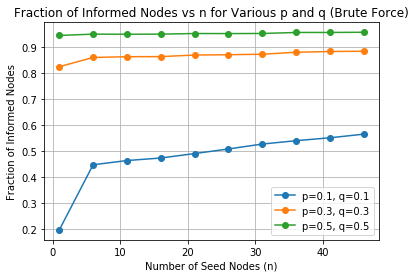

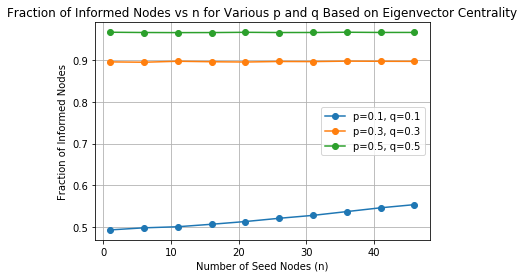

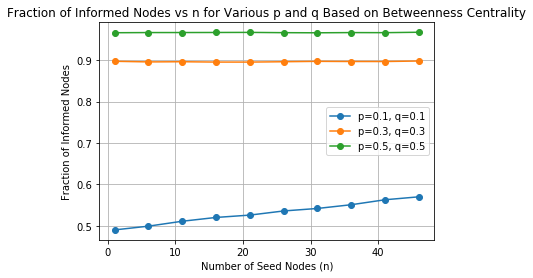

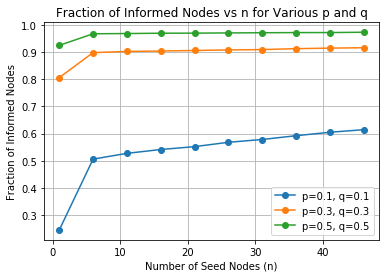

In [75]:
# Function to simulate the spread of information across two graphs (brute force)
def spread_information_cross_networks_brute_force(graph1, graph2, n, p, q, common_nodes, iterations=1000):
    nodes = list(set(graph1.nodes).intersection(graph2.nodes))
    
    graph1_sub = graph1.subgraph(nodes)
    graph2_sub = graph2.subgraph(nodes)
    

    # Combining 2 networks to find best nodes to spread information in multiplex network
    g_combined = nx.compose(graph1_sub, graph2_sub)

    total_spread = 0
    
    
    # Finding best nodes to spread information based on brute force
    top_nodes = find_best_informing_nodes_brute_force(g_combined, n)


    for _ in range(iterations):    
        
        informed_nodes = set(top_nodes)
        new_informed = set(top_nodes)

        while new_informed:
            current_new_informed = set()

            # Spread information in the SMS graph
            for node in new_informed:
                neighbors = list(g_combined.neighbors(node))
                for neighbor in neighbors:
                    if neighbor not in informed_nodes and random.random() < p:
                        current_new_informed.add(neighbor)

            # Update informed nodes
            new_informed = current_new_informed
            informed_nodes.update(new_informed)

        total_spread += len(informed_nodes)

    average_spread = total_spread / iterations
    return average_spread / (len(nodes))


# Function to plot fraction of informed nodes vs n for various p and q (brute force)
def plot_fraction_vs_n_for_multiple_p_q_brute_force(sms_graph, fb_friends_graph, p_values, q_values, common_nodes):
    n_values = list(range(1, 51, 5))

    plt.figure()

    for p, q in zip(p_values, q_values):
        fractions = []
        for n in n_values:
            fraction = spread_information_cross_networks_brute_force(sms_graph, fb_friends_graph, n, p, q, common_nodes)
            fractions.append(fraction)
        plt.plot(n_values, fractions, marker='o', label=f'p={p}, q={q}')

    plt.xlabel('Number of Seed Nodes (n)')
    plt.ylabel('Fraction of Informed Nodes')
    plt.title('Fraction of Informed Nodes vs n for Various p and q (Brute Force)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    
# Plotting for cross-network scenario (Brute Force)
plot_fraction_vs_n_for_multiple_p_q_brute_force(sms_graph, fb_friends_graph, p_values=[0.1, 0.3, 0.5], q_values=[0.1, 0.3, 0.5], common_nodes=common_nodes)
 
# Plotting for cross-network scenario based on eigenvector centrality of sms_graph
plot_fraction_vs_n_for_multiple_p_q_eigenvector_centrality(sms_graph, fb_friends_graph, p_values=[0.1, 0.3, 0.5], q_values=[0.1, 0.3, 0.5], common_nodes=common_nodes)
 
# Plotting for cross-network scenario based on betweenness centrality of sms_graph
plot_fraction_vs_n_for_multiple_p_q_centrality(sms_graph, fb_friends_graph, p_values=[0.1, 0.3, 0.5], q_values=[0.1, 0.3, 0.5], common_nodes=common_nodes)

# Plotting for cross-network scenario
plot_fraction_vs_n_for_multiple_p_q(sms_graph, fb_friends_graph, p_values=[0.1, 0.3, 0.5], q_values=[0.1, 0.3, 0.5], common_nodes=common_nodes)